In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [4]:
import shutil
from google.colab import output
import numpy as np
from math import sqrt

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

In [5]:
sparkCluster = SparkSession.builder\
                    .master('local[*]')\
                    .appName('k_means++')\
                    .getOrCreate()

sparkCluster.conf.set("spark.sql.repl.eagerEval.enabled", True)
sc = SparkContext.getOrCreate(conf=sparkCluster.conf)
sc

<SparkContext master=local[*] appName=k_means++>

In [6]:
!wget --no-check-certificate 'https://drive.google.com/u/0/uc?id=1fcE__1ezS6jUGOYfOhRfJRh0BV5y654z&export=download' -O 'C1.txt'
!wget --no-check-certificate 'https://drive.google.com/u/0/uc?id=16iZlV4c6TNZnkoZOwbrrUmSj0oFAsquV&export=download' -O 'C2.txt'
!wget --no-check-certificate 'https://drive.google.com/u/0/uc?id=1OF1Mrhj2FLkyqvmlCTSfQQ7gpZQUL9fo&export=download' -O 'C3.txt'


os.mkdir('/content/data')
sourceDir = '/content/'
targetDir = '/content/data'

files = os.listdir(sourceDir)
for file in files:
    if file.endswith('.txt'):
        txtPath = os.path.join(sourceDir, file)
        shutil.move(txtPath, targetDir)

output.clear()

In [48]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler


vector = VectorAssembler(inputCols=['x', 'y'], outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=False, withStd=True)
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures',
                                metricName='silhouette')


def process_data(data, filename):
    if filename == 'C1':
        data_parsed =  data.map(lambda line: np.array([float(x) for x in line.split(' ') if x]))
    else:
        data_parsed =  data.map(lambda line: np.array([float(x) for x in line.split('\t') if x]))
    data_parsed_sep = data_parsed.map(lambda x: (float(x[0]), float(x[1])))
    data_df = sparkCluster.createDataFrame(data_parsed_sep, ['x', 'y'])
    data_vec = vector.transform(data_df)
    scaledModel = scaler.fit(data_vec)
    data_scaled = scaledModel.transform(data_vec)
    return data_scaled


def make_cluster(data, filename):
    silhouette_score=[]
    print(f'text file: {filename}')
    for i in range(2, 26):
        kmeans = KMeans(featuresCol='scaledFeatures', k=i, initMode='k-means||')
        model = kmeans.fit(data)
        predictions = model.transform(data)
        score = evaluator.evaluate(predictions)
        silhouette_score.append(score)
        centers = model.clusterCenters()
        print('Silhouette Score for k =',i,'is',score)
    print('-'*50)
    return silhouette_score, centers


c1 = sc.textFile('/content/data/C1.txt')
c1_processed = process_data(c1, 'C1')

c2 = sc.textFile('/content/data/C2.txt')
c2_processed = process_data(c2, 'C2')

c3 = sc.textFile('/content/data/C3.txt')
c3_processed =  process_data(c3, 'C3')

c1_score, c1_centers = make_cluster(c1_processed, 'C1')
c2_score, c2_centers = make_cluster(c2_processed, 'C2')
c3_score, c3_centers = make_cluster(c3_processed, 'C3')


text file: C1
Silhouette Score for k = 2 is 0.5217850362317699
Silhouette Score for k = 3 is 0.5743109756415387
Silhouette Score for k = 4 is 0.545297069749991
Silhouette Score for k = 5 is 0.5471080132440432
Silhouette Score for k = 6 is 0.5654303010258906
Silhouette Score for k = 7 is 0.5732704219451847
Silhouette Score for k = 8 is 0.5538514107248762
Silhouette Score for k = 9 is 0.574407939852456
Silhouette Score for k = 10 is 0.5758111383310474
Silhouette Score for k = 11 is 0.5795859177403189
Silhouette Score for k = 12 is 0.6093870655574014
Silhouette Score for k = 13 is 0.633916997643729
Silhouette Score for k = 14 is 0.6373670519183674
Silhouette Score for k = 15 is 0.6299800286216337
Silhouette Score for k = 16 is 0.6241917312821541
Silhouette Score for k = 17 is 0.6253528448006395
Silhouette Score for k = 18 is 0.6302545891373151
Silhouette Score for k = 19 is 0.6090000817062879
Silhouette Score for k = 20 is 0.6130029579065379
Silhouette Score for k = 21 is 0.60514908730043

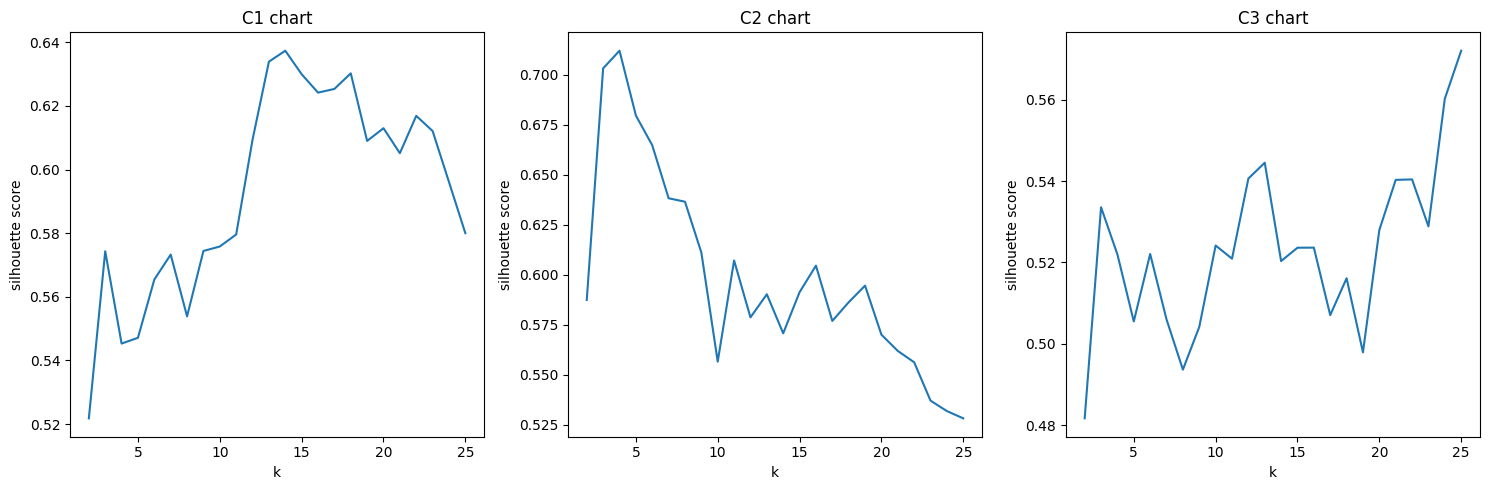

In [49]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(2, 26), c1_score)
axs[0].set_xlabel('k')
axs[0].set_ylabel('silhouette score')
axs[0].set_title('C1 chart')

axs[1].plot(range(2, 26), c2_score)
axs[1].set_xlabel('k')
axs[1].set_ylabel('silhouette score')
axs[1].set_title('C2 chart')

axs[2].plot(range(2, 26), c3_score)
axs[2].set_xlabel('k')
axs[2].set_ylabel('silhouette score')
axs[2].set_title('C3 chart')

plt.tight_layout()
plt.show();

In [50]:
print("Cluster Centers for C1: ")
for center in c1_centers:
    print(center)

Cluster Centers: 
[1.78772109 1.59214955]
[4.3203903 2.5019301]
[1.73244266 3.53404062]
[4.29920311 3.83788201]
[1.29089112 4.25208183]
[3.1287173  1.19280537]
[2.72086417 1.74832799]
[3.05762341 4.29617968]
[2.84336105 3.69488994]
[1.4639384  2.83075814]
[4.90127416 3.24604602]
[3.85535572 4.38023695]
[4.49104753 3.25702177]
[2.30565156 2.81913417]
[3.7196662  3.53442246]
[1.22595862 1.63496508]
[4.92723168 2.40435463]
[1.40905373 2.3344847 ]
[3.9801452 1.529685 ]
[2.48927619 3.26657859]
[2.87505388 4.85220537]
[3.27772876 2.24897084]
[2.24027888 2.13377874]
[3.25090463 2.96546232]
[2.00009391 4.0935899 ]


In [51]:
print("Cluster Centers for C2: ")
for center in c2_centers:
    print(center)

Cluster Centers for C2: 
[1.74467248 0.57436469]
[1.07907891 2.77905393]
[0.56854993 0.45373694]
[3.24775462 3.20049922]
[3.34680519 0.72799952]
[3.10643929 2.57895912]
[2.0242589 2.8116863]
[3.51742098 1.21355894]
[2.23257126 1.15435089]
[3.19698174 1.38920581]
[0.7507135  1.45281058]
[1.14785081 3.36200558]
[0.72810034 2.45861213]
[1.8481285 1.1931648]
[1.23055465 2.24668864]
[3.32722861 2.21149846]
[0.62625715 3.03905586]
[1.49582779 1.34430476]
[3.47802294 2.75641005]
[2.26072755 0.75106302]
[0.74522133 0.42174267]
[2.32494289 2.87684028]
[1.34186713 0.5446752 ]
[1.30731653 0.98026085]
[2.07376659 0.43339149]


In [52]:
print("Cluster Centers for C3: ")
for center in c3_centers:
    print(center)

Cluster Centers for C3: 
[2.09020461 1.25717811]
[3.04014937 4.47778691]
[0.82107027 2.68166649]
[1.07021673 3.58313964]
[3.34387076 3.57494857]
[3.06475824 2.34155491]
[4.18771524 2.05250102]
[2.23255771 1.89923693]
[1.893475   2.71984094]
[1.8131306  3.98788269]
[2.46406699 3.19488275]
[4.00261056 0.85824249]
[3.86533743 3.85971478]
[1.62225098 1.96697781]
[2.32622308 0.51057692]
[3.50372491 2.01850457]
[3.07379416 2.95606745]
[1.46987846 1.02734265]
[2.59506152 4.0008844 ]
[3.59897237 1.29600987]
[2.8165658  1.62417288]
[3.94847018 2.88625595]
[1.65491729 3.26858842]
[0.7662181  1.82412176]
[2.99709608 0.79986484]
